In [2]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)
from colors import *

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [4]:
init_notebook()
figsize = (9,2.60)
fontsize = 16

In [5]:
dataf = "../../data/instrumentationoverhead.csv"

In [6]:
!cat $dataf

workload,baseline,no persist ops,no check memory,no instrumentation
a,1459542987,1358375095,1340927411,1352536562
b,1371086625,1410048431,1366888449,1373790471
c,1370897921,1397805483,1361734829,1361239389
d,2868266558,2512454604,2439271265,2432614358
e,473819346,62356803,65466578,64035420
f,2065922041,1962712880,1943416477,1938665647
g,1604979477,1331466498,1321035226,1313795446
workload,baseline,no persist ops,no check memory,no instrumentation
a,1476875492,1350552085,1337834728,1344839473
b,1393235456,1393221643,1377807028,1382636575
c,1365166801,1417195861,1372439579,1368558931
d,2913272407,2535256600,2476155205,2445171804
e,476223738,62738143,64025571,64524845
f,2074870658,1978596797,1937189606,1935739754
g,1601575609,1313057384,1316464692,1322663219
workload,baseline,no persist ops,no check memory,no instrumentation
a,1462274724,1355215712,1344876960,1339458890
b,1372825846,1402548260,1369204595,1376799418
c,1366054504,1405723192,1373990035,1358501507
d,2845723664,2485071731,2441

In [6]:
!sha256sum $dataf

94e54b3791a4412f7911a5d25e3d2906ffa5adca5f95b9fce80b63bcbe9ccfe4  ../../data/instrumentationoverhead.csv


In [52]:
df = pd.read_csv(dataf)
df = df.T
del df[7]
del df[15]
del df[23]
del df[31]
df = df.T
df.index = range(len(df))
del df['workload']

cols = ['baseline','no persist ops','no check memory','no instrumentation']
df[cols] = df[cols].apply(pd.to_numeric)
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
baseline,1459542987,1371086625,1370897921,2868266558,473819346,2065922041,1604979477,1476875492,1393235456,1365166801,2913272407,476223738,2074870658,1601575609,1462274724,1372825846,1366054504,2845723664,472496290,2066761100,1579814609,1481270129,1373723626,1363748673,2867309531,477440192,2069108976,1586620630,1459922455,1371424529,1354248012,2871712352,470350215,2070316538,1577131479
no persist ops,1358375095,1410048431,1397805483,2512454604,62356803,1962712880,1331466498,1350552085,1393221643,1417195861,2535256600,62738143,1978596797,1313057384,1355215712,1402548260,1405723192,2485071731,62449947,1963147791,1314135983,1363407071,1390594909,1399470477,2486745137,64155392,1964211170,1329665980,1348464595,1400647315,1402156108,2480110429,62881566,1966796213,1329207809
no check memory,1340927411,1366888449,1361734829,2439271265,65466578,1943416477,1321035226,1337834728,1377807028,1372439579,2476155205,64025571,1937189606,1316464692,1344876960,1369204595,1373990035,2441918462,64167568,1930316221,1317619296,1337466914,1368578390,1378548429,2446433444,64316741,1935294942,1314700795,1338587565,1371344472,1372671758,2452144590,64210004,1931392484,1320039611
no instrumentation,1352536562,1373790471,1361239389,2432614358,64035420,1938665647,1313795446,1344839473,1382636575,1368558931,2445171804,64524845,1935739754,1322663219,1339458890,1376799418,1358501507,2434392246,63426822,1938864771,1312985907,1343221281,1369024370,1359557249,2441922640,64367470,1948805204,1309890021,1339441011,1356097304,1408453136,2427839213,63869265,1935999869,1311024469


In [68]:
df_sum = pd.DataFrame()
for i in range(0, 5):
    idx = list(range(0+7*i, 0+7*(i+1)))
    
    if (i == 0):
        print(df.T[idx])
        df_sum = df.T[idx]
    else:
        df_tmp = df.T[idx].copy(deep=True).T
        print(df_tmp.T)
        df_tmp.index = list(range(0, 7))
        df_sum = df_sum.add(df_tmp.T)

df_avg = (df_sum/5).T
df_avg.index = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
df_avg

                             0           1           2           3          4           5           6
baseline            1459542987  1371086625  1370897921  2868266558  473819346  2065922041  1604979477
no persist ops      1358375095  1410048431  1397805483  2512454604   62356803  1962712880  1331466498
no check memory     1340927411  1366888449  1361734829  2439271265   65466578  1943416477  1321035226
no instrumentation  1352536562  1373790471  1361239389  2432614358   64035420  1938665647  1313795446
                            7           8           9           10         11          12          13
baseline            1476875492  1393235456  1365166801  2913272407  476223738  2074870658  1601575609
no persist ops      1350552085  1393221643  1417195861  2535256600   62738143  1978596797  1313057384
no check memory     1337834728  1377807028  1372439579  2476155205   64025571  1937189606  1316464692
no instrumentation  1344839473  1382636575  1368558931  2445171804   64524845  193

,baseline,no persist ops,no check memory,no instrumentation
a,1.467977e+09,1.355203e+09,1.339939e+09,1.343899e+09
b,1.376459e+09,1.399412e+09,1.370765e+09,1.371670e+09
c,1.364023e+09,1.404470e+09,1.371877e+09,1.371262e+09
d,2.873257e+09,2.499928e+09,2.451185e+09,2.436388e+09
e,4.740660e+08,6.291637e+07,6.443729e+07,6.404476e+07
f,2.069396e+09,1.967093e+09,1.935522e+09,1.939615e+09
g,1.590024e+09,1.323507e+09,1.317972e+09,1.314072e+09


In [69]:
df_norm = df_avg.T/df_avg['no instrumentation'].T
df_norm = df_norm.T

In [70]:
df_norm

,baseline,no persist ops,no check memory,no instrumentation
a,1.092327,1.008411,0.997053,1.0
b,1.003492,1.020225,0.999340,1.0
c,0.994721,1.024217,1.000448,1.0
d,1.179310,1.026079,1.006073,1.0
e,7.402103,0.982381,1.006129,1.0
f,1.066911,1.014167,0.997890,1.0
g,1.209998,1.007180,1.002968,1.0


In [71]:
Fig.config(fontsize+4, figsize)

Plot saved as `plots/pathfinding/instrumentationoverhead.png`

Plot saved as `plots/pathfinding/instrumentationoverhead.png`

Using pdfcrop on `plots/pathfinding/instrumentationoverhead.png` with command `pdfcrop plots/pathfinding/instrumentationoverhead.pdf plots/pathfinding/instrumentationoverhead.pdf`

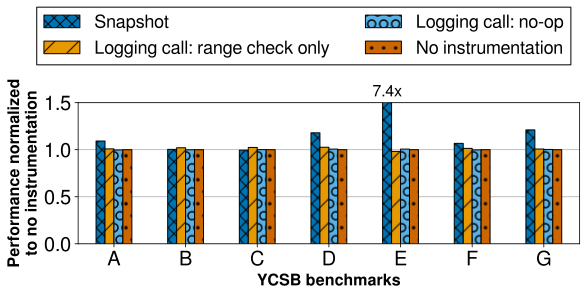

In [78]:
plt.rcParams["font.family"] = "freesans"
df_norm = capitalize_index(capitalize_index(df_norm.T).T)

label_trans_map = {
    'Baseline': 'Snapshot', 
    'No persist ops': 'Logging call: range check only',
    'No check memory': 'Logging call: no-op',
}

ax = (rename_cols(df_norm, label_trans_map, inplace=False)).plot.bar(**Fig.get_kwargs(cmap=None))
f = Fig(ax)
ax.set_ylim((0, 1.5))

f.fmt_label('YCSB benchmarks', 'Performance normalized\nto no instrumentation', fontsize=fontsize)
f.add_bar_labels([False]*4 + [True, False, False] + [False]*21, precision=2, fontsize=fontsize, over_fig=True, alpha=0, label_off_frac=0.02)
f.xrot(rot=0)
f.fmt_grid(axis='y')
ax.set_yticks(np.arange(0, 1.51, 0.5))


bars = ax.patches
hatches = ''.join(h*len(df_norm) for h in 'x/O.')

for bar, hatch in zip(bars, hatches):
    if hatch == 'x':
        hatch = 'xx'
    bar.set_hatch(hatch)

    
f.fmt_legend(fontsize=fontsize+2, ncol=2, y_off_scale=1.2, x_off_scale=0.9)

save_fig('instrumentationoverhead')

In [73]:
df_norm

,Baseline,No persist ops,No check memory,No instrumentation
A,1.092327,1.008411,0.997053,1.0
B,1.003492,1.020225,0.999340,1.0
C,0.994721,1.024217,1.000448,1.0
D,1.179310,1.026079,1.006073,1.0
E,7.402103,0.982381,1.006129,1.0
F,1.066911,1.014167,0.997890,1.0
G,1.209998,1.007180,1.002968,1.0
